In [1]:
import io
import pandas as pd
from PIL import Image
from openpyxl import load_workbook
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision import transforms
from scripts.models import frcnn
from scripts.data.augmentations import get_transform

# Set device
device = torch.device('cpu')
num_classes = 3
THRESHOLD = 0.3  # Lowered confidence threshold for Faster R-CNN

# Load pre-trained Faster R-CNN model
model_path = os.path.abspath(os.path.join(os.path.dirname('__file__'), 'saved_models', 'model_frcnn_32.pth'))
model = frcnn.get_model(num_classes)
model.to(device)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()


# Construct the absolute path for the Excel file
excel_path = os.path.abspath(os.path.join(os.path.dirname('__file__'), 'Blueberries.xlsx'))

# Load the workbook using openpyxl to check for embedded images
wb = load_workbook(excel_path, data_only=True)
ws = wb["Sheet1"]

# Also load with pandas to get the berry counts
df = pd.read_excel(excel_path)

# Extract and list all images in the worksheet
images = ws._images

# Save extracted images into an array
image_data = []
for img in images:
    # Convert image to byte stream and then load it as a PIL image
    img_bytes = io.BytesIO(img._data())
    pil_image = Image.open(img_bytes)
    image_data.append(pil_image)

# Combine extracted images with the blueberry count column
berry_counts = df['Blueberries'].dropna().tolist()

# Ensure both lists have the same length before pairing them
image_berry_array = list(zip(image_data[:len(berry_counts)], berry_counts))

# # Object detection on each image
# for idx, (pil_image, berry_count) in enumerate(image_berry_array):
#     # Convert PIL image to tensor
#     transform = transforms.ToTensor()
#     image = transform(pil_image).unsqueeze(0)

#     with torch.inference_mode():
#         predictions = model(image.to(device))
#         pred = predictions[0]

#     # Filter predictions by score threshold
#     keep = pred["scores"] >= THRESHOLD
#     pred_boxes = pred["boxes"][keep]

#     # Draw bounding boxes on the image
#     output_image = draw_bounding_boxes(image.squeeze(0), pred_boxes, colors="blue")

#     # Convert image to format suitable for plotting
#     output_image_np = output_image.permute(1, 2, 0).numpy()

#     # Display the image with bounding boxes
#     plt.figure(figsize=(8, 8))
#     plt.imshow(output_image_np)
#     plt.axis('off')
#     plt.title(f"Image {idx + 1}: Berry Count = {berry_count}")
#     plt.show()

print("Object detection completed on all images.")

C:\Users\quydu\AppData\Local\Temp\ipykernel_26644\2386900835.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=t

Object detection completed on all images.


In [5]:
import torch
from scripts.models.frcnn import get_model
import os

# Set the path to your model
model_path = os.path.abspath(os.path.join(os.path.dirname('__file__'), 'saved_models', 'model_frcnn_32.pth'))

# Load the model
num_classes = 3  # As specified in the training code
model = get_model(num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Print the entire model architecture
print("----- Model Architecture -----")
print(model)

# Print the model’s box predictor (output layer) to see if it's set for 3 classes
print("\n----- Model Output Layer -----")
print(model.roi_heads.box_predictor)


----- Model Architecture -----
FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

C:\Users\quydu\AppData\Local\Temp\ipykernel_17072\4257452322.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=t

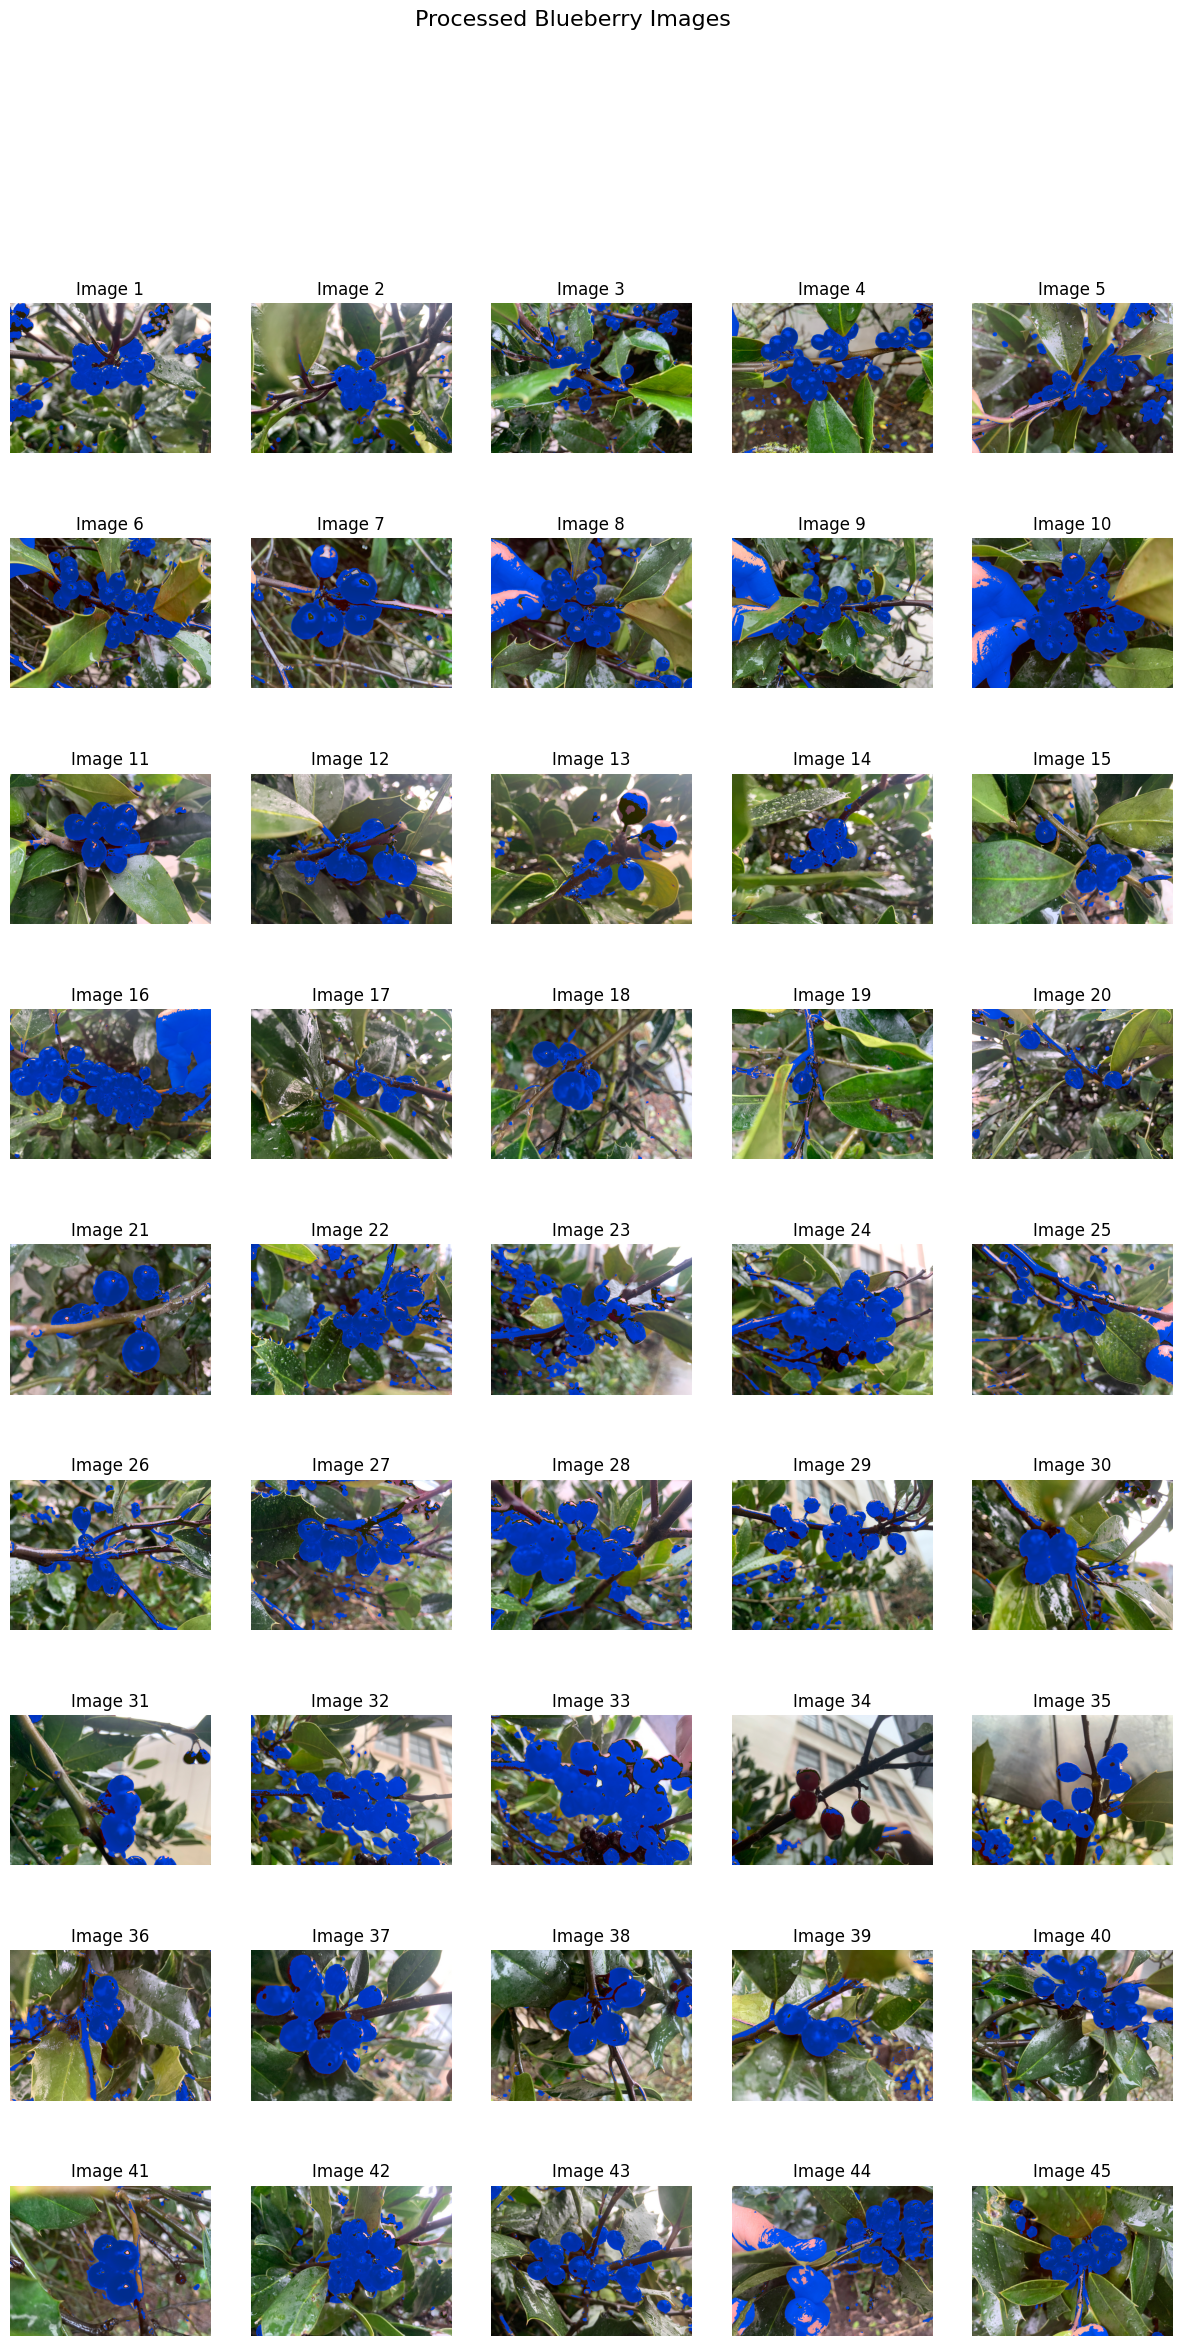

In [9]:
def replace_red_with_natural_blue(image):
    # Convert image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define lower and upper bounds for red color in HSV (more restrictive)
    lower_red1 = np.array([0, 100, 80])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 100, 80])
    upper_red2 = np.array([180, 255, 255])

    # Create masks to detect red color
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = mask1 | mask2

    # Apply an additional mask based on Saturation
    saturation_mask = hsv[:, :, 1] > 100  # Keep only high-saturation areas
    combined_mask = cv2.bitwise_and(red_mask, red_mask, mask=saturation_mask.astype(np.uint8))

    # Slightly blur the mask to make it smoother
    combined_mask = cv2.GaussianBlur(combined_mask, (5, 5), 0)

    # Convert image to LAB color space
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(image_lab)

    # Adjust LAB channels for a natural, darker blue look
    l[combined_mask > 0] = np.clip(l[combined_mask > 0] * 0.3, 0, 255)  # Darken even more
    a[combined_mask > 0] = np.clip(a[combined_mask > 0] - 70, 0, 255)  # Reduce redness moderately
    b[combined_mask > 0] = np.clip(b[combined_mask > 0] + 120, 0, 255)  # Increase blueness more significantly

    # Merge channels and convert back to BGR
    modified_lab = cv2.merge((l, a, b))
    result = cv2.cvtColor(modified_lab, cv2.COLOR_LAB2BGR)

    return result

processed_images = []

# Process all images
for idx, pil_image in enumerate(image_data):
    # Convert PIL image to OpenCV format
    image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    # Process the image
    result = replace_red_with_natural_blue(image)

    if result is not None:
        processed_images.append((f"Image {idx+1}", result))

# Display all processed images
fig, axes = plt.subplots(9, 5, figsize=(15, 27))
fig.suptitle('Processed Blueberry Images', fontsize=16)
axes = axes.flatten()

for idx, (filename, image) in enumerate(processed_images):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[idx].imshow(image_rgb)
    axes[idx].axis('off')
    axes[idx].set_title(f'{filename}')

plt.show()

In [11]:
# Define the folder path to save the processed images
save_folder = os.path.join('jerome', 'images_blue', 'final attempt')
os.makedirs(save_folder, exist_ok=True)

# Save the processed images
for idx, (filename, image) in enumerate(processed_images):
    # The images are already in BGR format as required by OpenCV, so save them directly
    save_path = os.path.join(save_folder, f'{filename}.jpg')
    
    # Save the image
    cv2.imwrite(save_path, image)

print(f"All images have been successfully saved to {save_folder}.")


All images have been successfully saved to jerome\images_blue\final attempt.
